In [1]:
### Load and preprocess w/ 50k/10k/10k train/val/test split ###

from collections import Counter
import keras_tuner as kt
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf


# Load dataset
(X_train_val_unscaled, y_train_val), (X_test_unscaled, y_test) = tf.keras.datasets.mnist.load_data()

# Scale pixel values to b/w 0 and 1
X_train_val = (X_train_val_unscaled / 255).astype(np.float32)
X_test = (X_test_unscaled / 255).astype(np.float32)

# Shuffle + stratified split the 60k X_train_val into 50k/10k X_train/X_val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42
)

# Add 1 channel to the input arrays (CNNs require an axis for number of channels)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Print info on the preprocessed data
print(f'Train: num_samples={len(X_train)} | priors={dict(sorted(Counter(y_train).items()))}')
print(f'Val: num_samples={len(X_val)} | priors={dict(sorted(Counter(y_val).items()))}')
print(f'Test: num_samples={len(X_test)} | priors={dict(sorted(Counter(y_test).items()))}')

Train: num_samples=48000 | priors={0: 4738, 1: 5394, 2: 4766, 3: 4905, 4: 4674, 5: 4337, 6: 4734, 7: 5012, 8: 4681, 9: 4759}
Val: num_samples=12000 | priors={0: 1185, 1: 1348, 2: 1192, 3: 1226, 4: 1168, 5: 1084, 6: 1184, 7: 1253, 8: 1170, 9: 1190}
Test: num_samples=10000 | priors={0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


In [ ]:
### Testing out a lower learning rate than the results of notebook 2c ###

# Define static hyperparameters based on previous 2 HPT experiments in notebooks 2b and 2c
num_conv_layers = 3
num_filters_first_layer = 16
num_filters_sub_layers = 32
kernel_size = 5
subsample_type = '5x5stride2'

dense_layer_size = 256
activation = 'relu'

dropout_rate = 0.2
learning_rate = 0.001 # Only hp that will vary

rotation_range = 0.05
zoom_range = 0.0
width_shift_range = 0.15
height_shift_range = 0.1


# Build the model
input_size = (28, 28, 1)
output_size = 10

model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(shape=input_size))

# Add augmentation layers directly into the model pipeline instead of using ImageDataGenerator
model.add(tf.keras.layers.RandomRotation(factor=rotation_range))
model.add(tf.keras.layers.RandomZoom(height_factor=zoom_range, width_factor=zoom_range))
model.add(tf.keras.layers.RandomTranslation(height_factor=height_shift_range, width_factor=width_shift_range))

for i in range(num_conv_layers):

    if i == 0:
        num_filters = num_filters_first_layer
    else:
        num_filters = num_filters_sub_layers
    model.add(
        tf.keras.layers.Conv2D(
            num_filters,
            kernel_size=kernel_size,
            activation=activation,
            padding='same'
        )
    )
    model.add(tf.keras.layers.BatchNormalization())

    if subsample_type == '2x2pool':
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    else: # '5x5stride2'
        model.add(
            tf.keras.layers.Conv2D(
                num_filters,
                kernel_size=5,
                activation=activation,
                padding='same',
                strides=2
            )
        )
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dropout(rate=dropout_rate))

model.add(tf.keras.layers.Flatten())
model.add(
    tf.keras.layers.Dense(
        dense_layer_size,
        activation=activation,
    )
)
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(output_size, activation='softmax'))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#####

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

# Train the best model
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/500
188/188 - 19s - 100ms/step - accuracy: 0.8166 - loss: 0.5790 - val_accuracy: 0.1998 - val_loss: 3.2660
Epoch 2/500
188/188 - 14s - 75ms/step - accuracy: 0.9537 - loss: 0.1508 - val_accuracy: 0.4558 - val_loss: 2.4902
Epoch 3/500
188/188 - 15s - 80ms/step - accuracy: 0.9664 - loss: 0.1091 - val_accuracy: 0.9694 - val_loss: 0.1063
Epoch 4/500
188/188 - 14s - 75ms/step - accuracy: 0.9719 - loss: 0.0889 - val_accuracy: 0.9842 - val_loss: 0.0539
Epoch 5/500
188/188 - 14s - 75ms/step - accuracy: 0.9768 - loss: 0.0751 - val_accuracy: 0.9890 - val_loss: 0.0397
Epoch 6/500
188/188 - 14s - 74ms/step - accuracy: 0.9792 - loss: 0.0680 - val_accuracy: 0.9840 - val_loss: 0.0532
Epoch 7/500
188/188 - 14s - 73ms/step - accuracy: 0.9813 - loss: 0.0609 - val_accuracy: 0.9866 - val_loss: 0.0418
Epoch 8/500
188/188 - 14s - 74ms/step - accuracy: 0.9822 - loss: 0.0571 - val_accuracy: 0.9927 - val_loss: 0.0298
Epoch 9/500
188/188 - 14s - 74ms/step - accuracy: 0.9833 - loss: 0.0535 - val_accuracy:

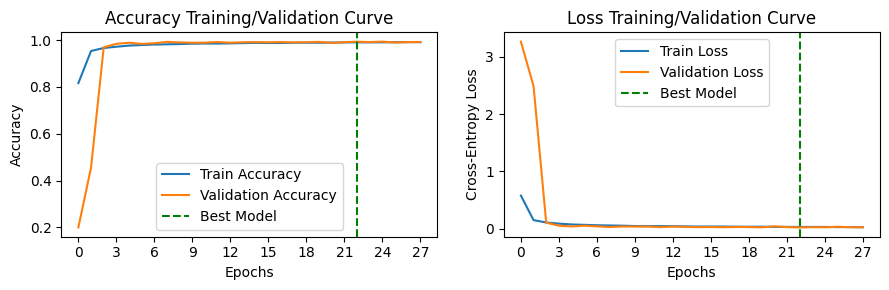

Final Results after 22 epochs:
Accuracy: Train=99.06% | Val=99.34%
Loss: Train=0.0308 | Val=0.0229


In [3]:
### Plot training and validation curves ###

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Accuracies plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy Training/Validation Curve')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))

# Losses plot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss Training/Validation Curve')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Cross-Entropy Loss')
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Add vertical trace for best model
restore_weights_idx = -early_stopping.patience - 1
best_epoch = len(history.history['accuracy']) + restore_weights_idx
axes[0].axvline(x=best_epoch, color='green', linestyle='--', label='Best Model')
axes[1].axvline(x=best_epoch, color='green', linestyle='--', label='Best Model')

# Show plots
axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

print(f'Final Results after {best_epoch} epochs:')
print(f'Accuracy: Train={history.history['accuracy'][restore_weights_idx] * 100:.2f}% | Val={history.history['val_accuracy'][restore_weights_idx] * 100:.2f}%')
print(f'Loss: Train={history.history['loss'][restore_weights_idx]:.4f} | Val={history.history['val_loss'][restore_weights_idx]:.4f}')

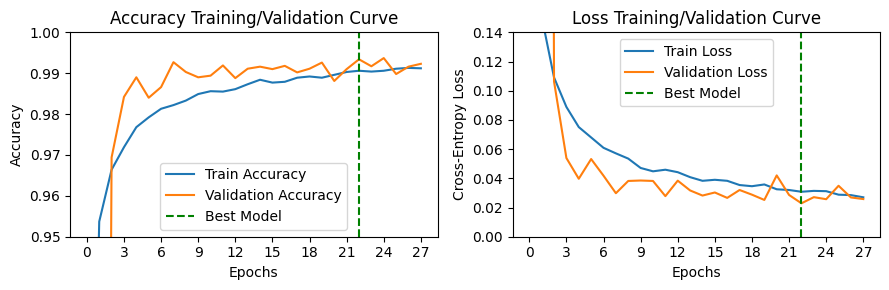

Final Results after 22 epochs:
Accuracy: Train=99.06% | Val=99.34%
Loss: Train=0.0308 | Val=0.0229


In [36]:
### Replotting the data for this model (model no longer in memory) ###
 
metrics = {
    'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    'accuracy': [0.8166, 0.9537, 0.9664, 0.9719, 0.9768, 0.9792, 0.9813, 0.9822, 0.9833, 0.9849, 0.9856, 0.9855, 0.9861, 0.9873,
                 0.9884, 0.9877, 0.9879, 0.9889, 0.9892, 0.9889, 0.9896, 0.9903, 0.9906, 0.9904, 0.9906, 0.9911, 0.9913, 0.9912],
    'val_accuracy': [0.1998, 0.4558, 0.9694, 0.9842, 0.9890, 0.9840, 0.9866, 0.9927, 0.9903, 0.9890, 0.9894, 0.9919, 0.9888, 0.9911,
                     0.9916, 0.9910, 0.9918, 0.9902, 0.9911, 0.9926, 0.9881, 0.9910, 0.9934, 0.9917, 0.9937, 0.9898, 0.9916, 0.9923],
    'loss': [0.5790, 0.1508, 0.1091, 0.0889, 0.0751, 0.0680, 0.0609, 0.0571, 0.0535, 0.0471, 0.0448, 0.0459, 0.0442, 0.0408,
             0.0383, 0.0390, 0.0383, 0.0354, 0.0346, 0.0358, 0.0325, 0.0320, 0.0308, 0.0314, 0.0312, 0.0288, 0.0285, 0.0270],
    'val_loss': [3.2660, 2.4902, 0.1063, 0.0539, 0.0397, 0.0532, 0.0418, 0.0298, 0.0382, 0.0385, 0.0382, 0.0278, 0.0384, 0.0317,
                 0.0282, 0.0303, 0.0266, 0.0320, 0.0288, 0.0252, 0.0420, 0.0286, 0.0229, 0.0271, 0.0257, 0.0349, 0.0269, 0.0258]
}

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Accuracies plot
axes[0].plot(metrics['accuracy'], label='Train Accuracy')
axes[0].plot(metrics['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy Training/Validation Curve')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(.95, 1)
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))

# Losses plot
axes[1].plot(metrics['loss'], label='Train Loss')
axes[1].plot(metrics['val_loss'], label='Validation Loss')
axes[1].set_title('Loss Training/Validation Curve')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Cross-Entropy Loss')
axes[1].set_ylim(0, .14)
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Add vertical trace for best model
patience = 5
restore_weights_idx = -patience - 1
best_epoch = len(metrics['accuracy']) + restore_weights_idx
axes[0].axvline(x=best_epoch, color='green', linestyle='--', label='Best Model')
axes[1].axvline(x=best_epoch, color='green', linestyle='--', label='Best Model')

# Show plots
axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

print(f'Final Results after {best_epoch} epochs:')
print(f'Accuracy: Train={metrics['accuracy'][restore_weights_idx] * 100:.2f}% | Val={metrics['val_accuracy'][restore_weights_idx] * 100:.2f}%')
print(f'Loss: Train={metrics['loss'][restore_weights_idx]:.4f} | Val={metrics['val_loss'][restore_weights_idx]:.4f}')


In [ ]:
### Save the model ###
 
model.save('models/cnn_final_model.keras')

In [7]:
### Create and run GridSearchCV to test several learning rates ###

def build_model(hp):
    """Model building function."""

    # Define static hyperparameters based on previous 2 HPT experiments in notebooks 2b and 2c
    num_conv_layers = 3
    num_filters_first_layer = 16
    num_filters_sub_layers = 32
    kernel_size = 5
    subsample_type = '5x5stride2'

    dense_layer_size = 256
    activation = 'relu'
    dropout_rate = 0.2

    rotation_range = 0.05
    zoom_range = 0.0
    width_shift_range = 0.15
    height_shift_range = 0.1

    # Define learning rate as only hyperparameter
    learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.0005, 0.001, 0.003, 0.05], default=0.001)

    # Build the model
    input_size = (28, 28, 1)
    output_size = 10

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=input_size))

    # Add augmentation layers directly into the model pipeline instead of using ImageDataGenerator
    model.add(tf.keras.layers.RandomRotation(factor=rotation_range))
    # model.add(tf.keras.layers.RandomZoom(height_factor=zoom_range, width_factor=zoom_range)) # zoom_range = 0
    model.add(tf.keras.layers.RandomTranslation(height_factor=height_shift_range, width_factor=width_shift_range))

    for i in range(num_conv_layers):

        if i == 0:
            num_filters = num_filters_first_layer
        else:
            num_filters = num_filters_sub_layers
        model.add(
            tf.keras.layers.Conv2D(
                num_filters,
                kernel_size=kernel_size,
                activation=activation,
                padding='same'
            )
        )
        model.add(tf.keras.layers.BatchNormalization())

        if subsample_type == '2x2pool':
            model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        else: # '5x5stride2'
            model.add(
                tf.keras.layers.Conv2D(
                    num_filters,
                    kernel_size=5,
                    activation=activation,
                    padding='same',
                    strides=2
                )
            )
        model.add(tf.keras.layers.BatchNormalization())

        model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    model.add(tf.keras.layers.Flatten())
    model.add(
        tf.keras.layers.Dense(
            dense_layer_size,
            activation=activation,
        )
    )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(output_size, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


MAX_EPOCHS = 500
BATCH_SIZE = 256

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

tuner = kt.GridSearch(
    build_model,
    objective='val_loss',
    directory='tuning_results',
    project_name='cnn_data_aug_lr_gridsearch'
)

tuner.search(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    epochs=MAX_EPOCHS,
    verbose=2
)

Trial 5 Complete [00h 03m 34s]
val_loss: 0.04183219373226166

Best val_loss So Far: 0.023281531408429146
Total elapsed time: 00h 29m 49s


In [ ]:
### Testing out learning rate of 0.002 (slightly different from the 0.001, which was best in gridsearch) ###

# Define static hyperparameters based on previous 2 HPT experiments in notebooks 2b and 2c
num_conv_layers = 3
num_filters_first_layer = 16
num_filters_sub_layers = 32
kernel_size = 5
subsample_type = '5x5stride2'

dense_layer_size = 256
activation = 'relu'

dropout_rate = 0.2
learning_rate = 0.002 # Only hp that changed

rotation_range = 0.05
zoom_range = 0.0
width_shift_range = 0.15
height_shift_range = 0.1


# Build the model
input_size = (28, 28, 1)
output_size = 10

model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(shape=input_size))

# Add augmentation layers directly into the model pipeline instead of using ImageDataGenerator
model.add(tf.keras.layers.RandomRotation(factor=rotation_range))
model.add(tf.keras.layers.RandomZoom(height_factor=zoom_range, width_factor=zoom_range))
model.add(tf.keras.layers.RandomTranslation(height_factor=height_shift_range, width_factor=width_shift_range))

for i in range(num_conv_layers):

    if i == 0:
        num_filters = num_filters_first_layer
    else:
        num_filters = num_filters_sub_layers
    model.add(
        tf.keras.layers.Conv2D(
            num_filters,
            kernel_size=kernel_size,
            activation=activation,
            padding='same'
        )
    )
    model.add(tf.keras.layers.BatchNormalization())

    if subsample_type == '2x2pool':
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    else: # '5x5stride2'
        model.add(
            tf.keras.layers.Conv2D(
                num_filters,
                kernel_size=5,
                activation=activation,
                padding='same',
                strides=2
            )
        )
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dropout(rate=dropout_rate))

model.add(tf.keras.layers.Flatten())
model.add(
    tf.keras.layers.Dense(
        dense_layer_size,
        activation=activation,
    )
)
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(output_size, activation='softmax'))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

# Train the best model
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/500
188/188 - 18s - 98ms/step - accuracy: 0.8483 - loss: 0.4753 - val_accuracy: 0.0975 - val_loss: 5.8293
Epoch 2/500
188/188 - 14s - 74ms/step - accuracy: 0.9623 - loss: 0.1231 - val_accuracy: 0.3952 - val_loss: 2.3743
Epoch 3/500
188/188 - 14s - 74ms/step - accuracy: 0.9727 - loss: 0.0906 - val_accuracy: 0.9844 - val_loss: 0.0573
Epoch 4/500
188/188 - 14s - 74ms/step - accuracy: 0.9771 - loss: 0.0729 - val_accuracy: 0.9857 - val_loss: 0.0508
Epoch 5/500
188/188 - 14s - 74ms/step - accuracy: 0.9795 - loss: 0.0673 - val_accuracy: 0.9841 - val_loss: 0.0537
Epoch 6/500
188/188 - 14s - 74ms/step - accuracy: 0.9813 - loss: 0.0600 - val_accuracy: 0.9902 - val_loss: 0.0321
Epoch 7/500
188/188 - 14s - 74ms/step - accuracy: 0.9837 - loss: 0.0531 - val_accuracy: 0.9866 - val_loss: 0.0539
Epoch 8/500
188/188 - 14s - 74ms/step - accuracy: 0.9846 - loss: 0.0494 - val_accuracy: 0.9897 - val_loss: 0.0333
Epoch 9/500
188/188 - 14s - 74ms/step - accuracy: 0.9850 - loss: 0.0476 - val_accuracy: 

In [16]:
### Testing out learning rate of 0.0008 (slightly different from the 0.001, which was best in gridsearch) ###

# Define static hyperparameters based on previous 2 HPT experiments in notebooks 2b and 2c
num_conv_layers = 3
num_filters_first_layer = 16
num_filters_sub_layers = 32
kernel_size = 5
subsample_type = '5x5stride2'

dense_layer_size = 256
activation = 'relu'

dropout_rate = 0.2
learning_rate = 0.0008 # Only hp that changed

rotation_range = 0.05
zoom_range = 0.0
width_shift_range = 0.15
height_shift_range = 0.1


# Build the model
input_size = (28, 28, 1)
output_size = 10

model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(shape=input_size))

# Add augmentation layers directly into the model pipeline instead of using ImageDataGenerator
model.add(tf.keras.layers.RandomRotation(factor=rotation_range))
model.add(tf.keras.layers.RandomZoom(height_factor=zoom_range, width_factor=zoom_range))
model.add(tf.keras.layers.RandomTranslation(height_factor=height_shift_range, width_factor=width_shift_range))

for i in range(num_conv_layers):

    if i == 0:
        num_filters = num_filters_first_layer
    else:
        num_filters = num_filters_sub_layers
    model.add(
        tf.keras.layers.Conv2D(
            num_filters,
            kernel_size=kernel_size,
            activation=activation,
            padding='same'
        )
    )
    model.add(tf.keras.layers.BatchNormalization())

    if subsample_type == '2x2pool':
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    else: # '5x5stride2'
        model.add(
            tf.keras.layers.Conv2D(
                num_filters,
                kernel_size=5,
                activation=activation,
                padding='same',
                strides=2
            )
        )
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dropout(rate=dropout_rate))

model.add(tf.keras.layers.Flatten())
model.add(
    tf.keras.layers.Dense(
        dense_layer_size,
        activation=activation,
    )
)
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(output_size, activation='softmax'))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
)

# Train the best model
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/500
188/188 - 18s - 98ms/step - accuracy: 0.7760 - loss: 0.7171 - val_accuracy: 0.1152 - val_loss: 3.8391
Epoch 2/500
188/188 - 14s - 76ms/step - accuracy: 0.9450 - loss: 0.1762 - val_accuracy: 0.5375 - val_loss: 1.5791
Epoch 3/500
188/188 - 14s - 73ms/step - accuracy: 0.9650 - loss: 0.1140 - val_accuracy: 0.9706 - val_loss: 0.1002
Epoch 4/500
188/188 - 14s - 73ms/step - accuracy: 0.9713 - loss: 0.0920 - val_accuracy: 0.9873 - val_loss: 0.0438
Epoch 5/500
188/188 - 14s - 73ms/step - accuracy: 0.9748 - loss: 0.0798 - val_accuracy: 0.9876 - val_loss: 0.0429
Epoch 6/500
188/188 - 14s - 73ms/step - accuracy: 0.9790 - loss: 0.0684 - val_accuracy: 0.9873 - val_loss: 0.0442
Epoch 7/500
188/188 - 14s - 73ms/step - accuracy: 0.9803 - loss: 0.0624 - val_accuracy: 0.9882 - val_loss: 0.0393
Epoch 8/500
188/188 - 14s - 75ms/step - accuracy: 0.9817 - loss: 0.0574 - val_accuracy: 0.9890 - val_loss: 0.0369
Epoch 9/500
188/188 - 15s - 78ms/step - accuracy: 0.9837 - loss: 0.0555 - val_accuracy: 

In [33]:
### Testing out learning rate of 0.001, but with patience=10 ###

# Define static hyperparameters based on previous 2 HPT experiments in notebooks 2b and 2c
num_conv_layers = 3
num_filters_first_layer = 16
num_filters_sub_layers = 32
kernel_size = 5
subsample_type = '5x5stride2'

dense_layer_size = 256
activation = 'relu'

dropout_rate = 0.2
learning_rate = 0.001 # Only hp that changed

rotation_range = 0.05
zoom_range = 0.0
width_shift_range = 0.15
height_shift_range = 0.1


# Build the model
input_size = (28, 28, 1)
output_size = 10

model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(shape=input_size))

# Add augmentation layers directly into the model pipeline instead of using ImageDataGenerator
model.add(tf.keras.layers.RandomRotation(factor=rotation_range))
model.add(tf.keras.layers.RandomZoom(height_factor=zoom_range, width_factor=zoom_range))
model.add(tf.keras.layers.RandomTranslation(height_factor=height_shift_range, width_factor=width_shift_range))

for i in range(num_conv_layers):

    if i == 0:
        num_filters = num_filters_first_layer
    else:
        num_filters = num_filters_sub_layers
    model.add(
        tf.keras.layers.Conv2D(
            num_filters,
            kernel_size=kernel_size,
            activation=activation,
            padding='same'
        )
    )
    model.add(tf.keras.layers.BatchNormalization())

    if subsample_type == '2x2pool':
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    else: # '5x5stride2'
        model.add(
            tf.keras.layers.Conv2D(
                num_filters,
                kernel_size=5,
                activation=activation,
                padding='same',
                strides=2
            )
        )
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dropout(rate=dropout_rate))

model.add(tf.keras.layers.Flatten())
model.add(
    tf.keras.layers.Dense(
        dense_layer_size,
        activation=activation,
    )
)
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(output_size, activation='softmax'))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
)

# Train the best model
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/500
188/188 - 19s - 99ms/step - accuracy: 0.7901 - loss: 0.6686 - val_accuracy: 0.1088 - val_loss: 4.9614
Epoch 2/500
188/188 - 14s - 74ms/step - accuracy: 0.9530 - loss: 0.1535 - val_accuracy: 0.2716 - val_loss: 3.9623
Epoch 3/500
188/188 - 14s - 74ms/step - accuracy: 0.9654 - loss: 0.1097 - val_accuracy: 0.9813 - val_loss: 0.0618
Epoch 4/500
188/188 - 14s - 74ms/step - accuracy: 0.9714 - loss: 0.0906 - val_accuracy: 0.9839 - val_loss: 0.0548
Epoch 5/500
188/188 - 14s - 74ms/step - accuracy: 0.9753 - loss: 0.0774 - val_accuracy: 0.9869 - val_loss: 0.0428
Epoch 6/500
188/188 - 14s - 74ms/step - accuracy: 0.9793 - loss: 0.0667 - val_accuracy: 0.9817 - val_loss: 0.0558
Epoch 7/500
188/188 - 14s - 74ms/step - accuracy: 0.9806 - loss: 0.0619 - val_accuracy: 0.9883 - val_loss: 0.0375
Epoch 8/500
188/188 - 14s - 74ms/step - accuracy: 0.9822 - loss: 0.0557 - val_accuracy: 0.9895 - val_loss: 0.0307
Epoch 9/500
188/188 - 14s - 75ms/step - accuracy: 0.9834 - loss: 0.0529 - val_accuracy: 